# Importazione dati e ispezione preliminare
Come prima cosa, abbiamo importato le librerie utilizzate e stampato il path dei file messi a disposizione da kaggle per sapere da dove importarli.
Le librerie sono pandas per l'importazione e la manipolaziuone dei dati, e matplotlib e seaborn per generare grafici e analizzare i dati.
Il set di dati è la lista dei passeggeri a bordo del Titanic con alcune informazioni anagrafiche e d'imbarco, divisa in due parti: in una è specificato se il passeggero è sopravvissuto o meno all'affondamento, mentre nell'altra parte è da predirre. Viene anche fornito un file di esempio su come dovranno essere formattate le previsioni.

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Abbiamo osservato la struttura dei set di dati per capire che informazioni abbiamo a disposizione:

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Notiamo che alcune colonne presentano dei valori nulli che dovremo andare a gestire in seguito, che la colonna Ticket contiene un codice del biglietto da cui non riteniamo di poter ricavare informazioni utili, e che pandas ha ritenuto opportuno importare la colonna Age come se fosse di tipo float, che non ha senso e verrà corretto in seguito.

In [4]:
train['Survived'].value_counts(normalize=True)*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

Circa il 38% dei passeggeri sono sopravvissuti.

Vediamo poi quanti valori unici ci sono in ogni colonna:

In [5]:
both = pd.concat([train, test])
print('Valori unici nei dati:\n', both.nunique())

Valori unici nei dati:
 PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64


Osserviamo che Pclass ed Embarked assumono solo 3 valori ciascuna, che significa che ci sono 3 classi di bordo e 3 porti di imbarco.

Abbiamo anche unito il set di training e quello di test in un unico set, in modo che se è necessario manipolare un'intera colonna ciò possa avvenire in maniera uniforme su tutto il set.

## Gestione dati mancanti

In [6]:
print('Valori mancanti nei dati:\n', both.isnull().sum())

Valori mancanti nei dati:
 PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [7]:
age_na_percent = both['Age'].isnull().sum()/both['Age'].shape[0]
print(f'Percentuale di età mancanti nel set completo: {age_na_percent * 100:.2f}%')

cabin_na_percent = both['Cabin'].isnull().sum()/both['Cabin'].shape[0]
print(f'Percentuale di cabine mancanti nel set completo: {cabin_na_percent * 100:.2f}%')

Percentuale di età mancanti nel set completo: 20.09%
Percentuale di cabine mancanti nel set completo: 77.46%


Osserviamo che ci sono dei valori mancanti nelle colonne Embarked, Cabin, Age e Fare:
- La colonna Cabin presenta un numero elevato di dati mancanti, abbiamo inizialmente provato a trasformarla in un valore booleano che indica semplicemente se il numero di cabina è presente o meno, ma dopo aver constatato che questo dava risultati peggiori abbiamo deciso di rimuovere del tutto il dato;
- Nella colonna Age riempiamo i valori mancanti con l'età media in modo che questo valore "fittizio" influisca il meno possibile sull'addestramento del modello;
- Nella colonna Embarked mancano solo due valori, avendo visto che questa colonna può avere solo tre valori possibili li riempiamo con la moda ovvero il valore che compare più frequentemente nel dataset;
- Nella colonna Fare manca un solo valore, lo riempiamo con la media.

Risulta quindi questa funzione:

In [8]:
def fill_nullvalues(df):
    # riempio le età mancanti con la media
    meanAge = int(df['Age'].mean())
    df['Age'] = df['Age'].fillna(meanAge)
    # casto a int tutta la colonna
    df['Age'] = df['Age'].astype(int)
    # riempio l'unica tariffa mancante con la media
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    # questa colonna ha solo due dati mancanti, le popolo con la moda ovvero il valore che compare più spesso
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    # creo una colonna booleana che indica la presenza o meno del dato
    #df['has_cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
    # elimino la colonna cabin
    df.drop('Cabin', axis=1, inplace=True)

Oltre a gestire i dati mancanti viene anche eseguita la conversione dei tipi di dati della colonna Age float a integer.

Reimportiamo quindi i dati senza la colonna Ticket, li uniamo di nuovo in un unico set e applichiamo la funzione che si occupa dei dati mancanti.

In [9]:
# useless_cols = ['Survived', 'Name', 'Ticket']
useless_cols = ['Survived', 'Ticket']
relevant_cols = [i for i in train.columns if i not in useless_cols]

# train = pd.read_csv('/kaggle/input/titanic/train.csv', usecols = relevant_cols + ['Survived'])
# test = pd.read_csv('/kaggle/input/titanic/test.csv', usecols = relevant_cols)
train = pd.read_csv('train.csv', usecols = relevant_cols + ['Survived'])
test = pd.read_csv('test.csv', usecols = relevant_cols)

both = pd.concat([train, test])
fill_nullvalues(both)
print('Valori mancanti nei dati:\n', both.isnull().sum())

Valori mancanti nei dati:
 PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64


Stavolta gli unici dati mancanti sono i 418 valori da predirre nella colonna Survived.

## Analisi dati

In [10]:
both['Sex'].value_counts(normalize=True)*100

male      64.400306
female    35.599694
Name: Sex, dtype: float64

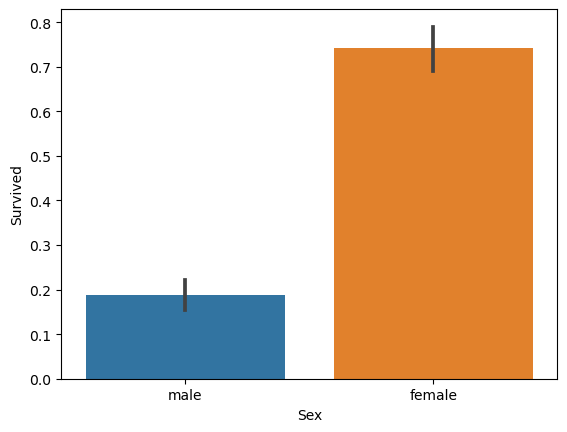

Female survival rate: 74.20%
Male survival rate: 18.89%


In [11]:
sb.barplot(x='Sex', y='Survived', data=both)
plt.show()

female = train.loc[train.Sex == 'female']["Survived"]
print(f"Female survival rate: {(sum(female)/len(female))*100:.2f}%")

male = train.loc[train.Sex == 'male']["Survived"]
print(f"Male survival rate: {(sum(male)/len(male))*100:.2f}%")

Osserviamo che sebbene i passeggeri siano al 64.4% uomini e il 35.6% donne le donne hanno un tasso di sopravvivenza del 74.2% mentre gli uomini meno del 18.8%.
Il sesso sembra quindi avere una forte correlazione con la probabilità di sopravvivenza.

Sapendo quindi che terremo questa colonna per addestrare il modello, trasformiamo le stringhe "male" e "female" nei valori numerici 0 e 1 per permetterne l'eleaborazione:

In [12]:
both.Sex = both.Sex.map({'male':0, 'female':1})

Abbiamo poi osservato la sopravvivenza in base alla classe di bordo:

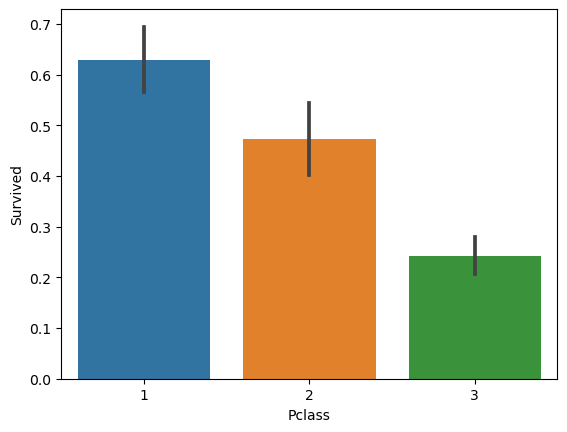

In [13]:
sb.barplot(x='Pclass', y='Survived', data=both)
plt.show()

Si nota chiaramente che, per ovvie ragioni, le chance di sopravvivenza sono più alte per i passeggeri in prima classe e più basse per quelli in terza.

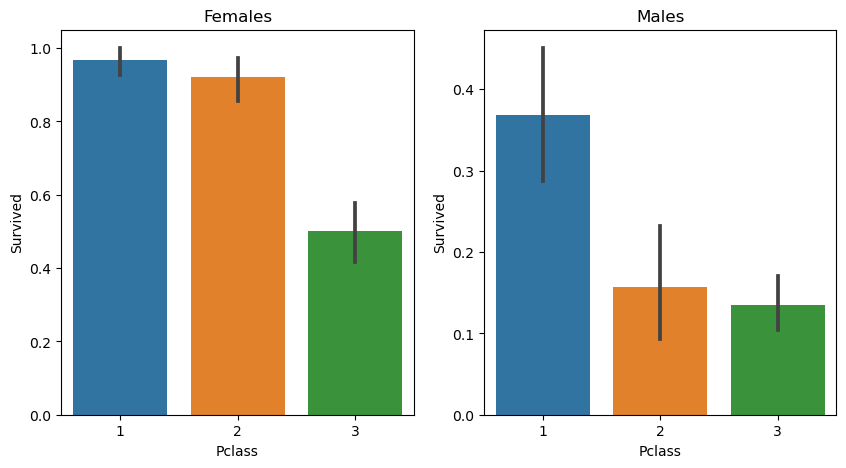

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sb.barplot(x='Pclass', y='Survived', data=both[both.Sex == 1], ax=ax[0])
ax[0].set_title('Females')
sb.barplot(x='Pclass', y='Survived', data=both[both.Sex == 0], ax=ax[1])
ax[1].set_title('Males')
plt.show()

Anche analizzando i dati discriminando tra uomini e donne il trend rimane.

Andiamo ora a cercare correlazione con il porto di imbarco:

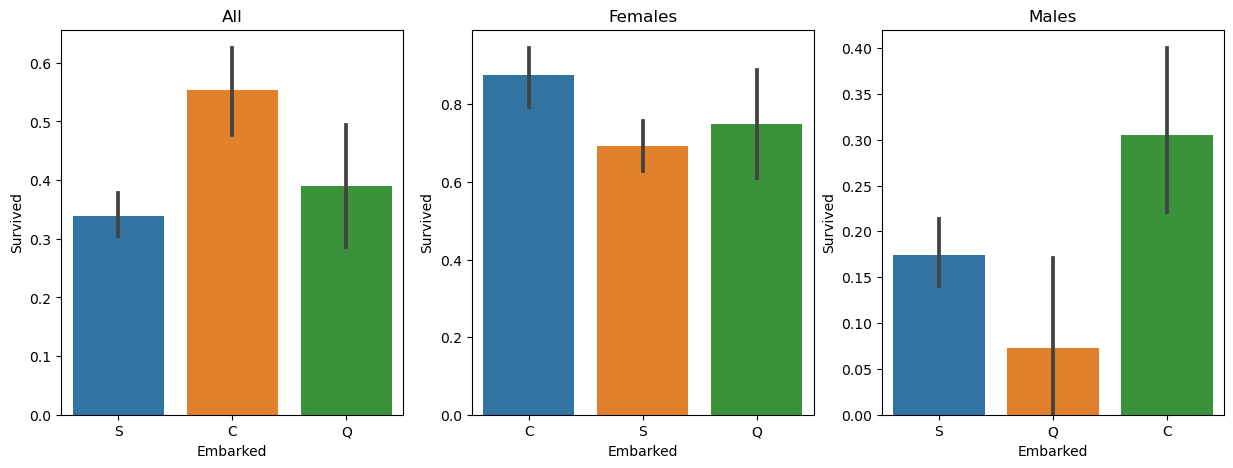

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sb.barplot(x='Embarked', y='Survived', data=both, ax=ax[0])
ax[0].set_title('All')
sb.barplot(x='Embarked', y='Survived', data=both[both.Sex == 1], ax=ax[1])
ax[1].set_title('Females')
sb.barplot(x='Embarked', y='Survived', data=both[both.Sex == 0], ax=ax[2])
ax[2].set_title('Males')
plt.show()

Notiamo che c'è una magiore quantità di sopravvissuti partiti da Cherbourg, seguita da Queenstown e infine da Southampton.

Se discriminiamo ulteriormente in base al sesso, vediamo che gli uomini sono sopravvissuti meno delle donne a prescindere dal porto di partenza, e che Cherbourg resta il porto con maggiore sopravvivenza in ambo i sessi.

## Aggiunta feature

In [16]:
def encode_port(df):
    df['Port'] = df.Embarked
    df.Port = df.Port.map({'S':0, 'Q':1, 'C':2})
    def m(x): return 0 if x=='Q' else ( 1 if x=='S' else 2)
    def f(x): return 3 if x=='S' else ( 4 if x=='Q' else 5)
    df['PortSex'] = df.apply(lambda x: m(x['Embarked']) if x['Sex'] == 0 else f(x['Embarked']), axis=1)
    df.drop('Embarked', axis=1, inplace=True)

encode_port(both)

Con la funzione qui sopra proviamo a creare due nuove colonne in cui la percentuale di sopravvivenza è espressa con un numero crescente, una in base al porto d'imbarco e l'altra tenendo in considerazione anche il sesso:

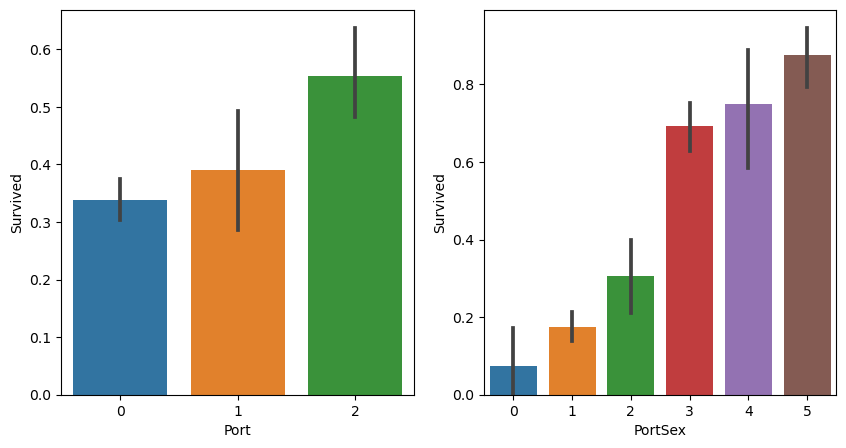

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sb.barplot(x='Port', y='Survived', data=both, ax=ax[0])
sb.barplot(x='PortSex', y='Survived', data=both, ax=ax[1])
plt.show()

Non essendoci però nessun ovvio nesso di causalità tra il luogo di imbarco e le chance di sopravvivenza l'utilità di questi dati andrà valutata in seguito.

Andiamo a vedere come influisce l'età:

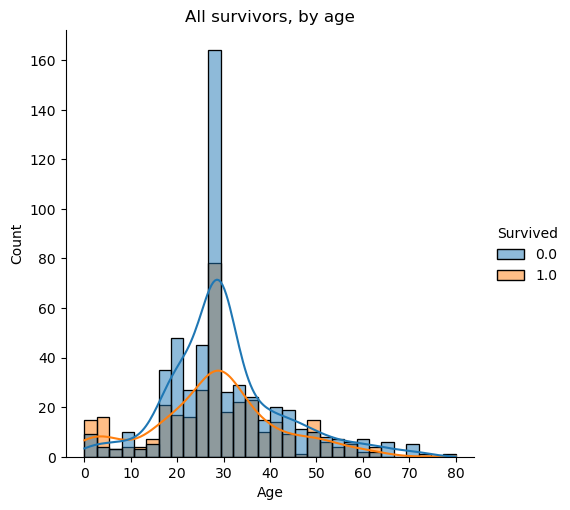

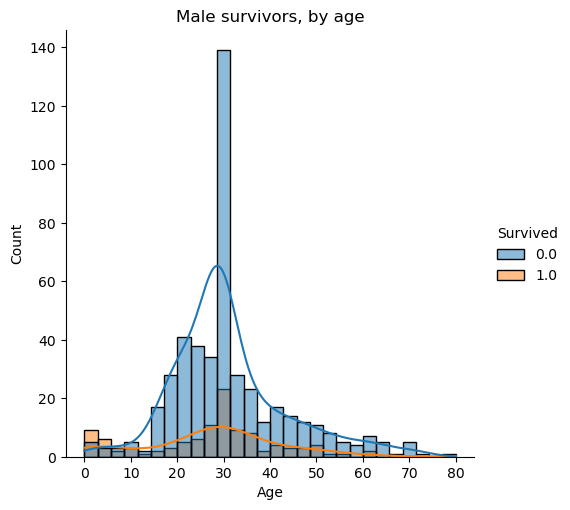

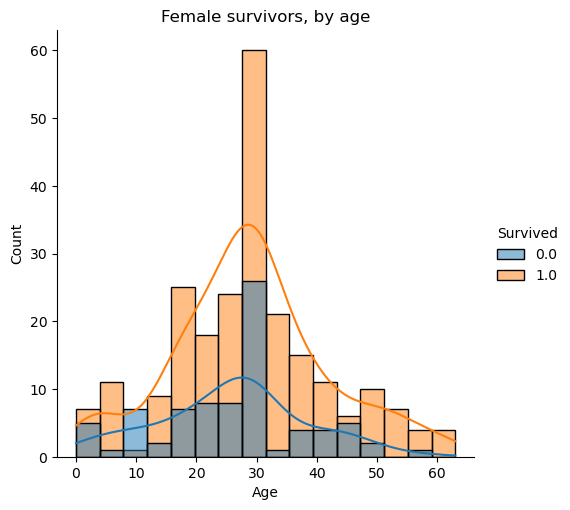

In [18]:
sb.displot(data=both[~both.index.duplicated()], x='Age', kde=True, hue='Survived')
plt.title('All survivors, by age')
plt.show()
sb.displot(data=both[(~both.index.duplicated()) & (both['Sex'] == 0)], x='Age', kde=True, hue='Survived')
plt.title('Male survivors, by age')
plt.show()
sb.displot(data=both[(~both.index.duplicated()) & (both['Sex'] == 1)], x='Age', kde=True, hue='Survived')
plt.title('Female survivors, by age')
plt.show()

Si nota che la maggior parte dei passeggeri ha attorno ai 30 anni e che tra i maschi c'è più percentuale di sopravvivenza che di morte solo tra i soggetti molto giovani mentre tra le donne in qualunque età.

Per quanto riguarda i parenti a bordo abbiamo a disposizione due dati: SibSp ("Siblings and Spouse") indica il numero di fratelli, sorelle e coniugi che ha a bordo un passeggero, Parch ("Parent and Children") indica i genitori e i figli.

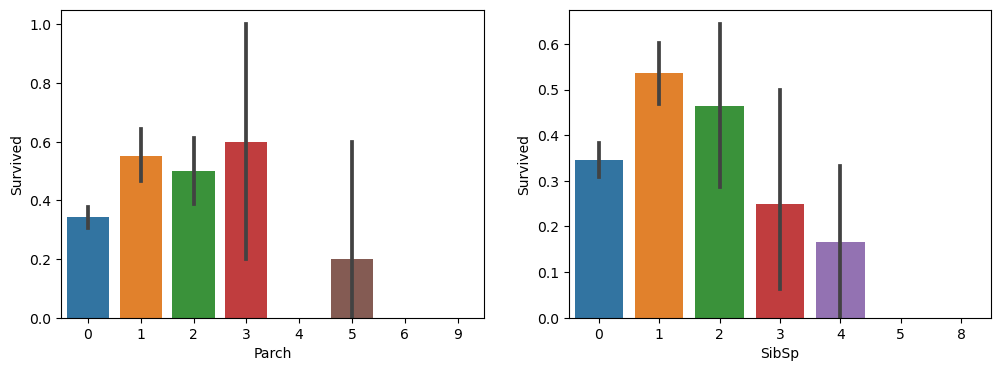

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sb.barplot(x='Parch', y='Survived', data=both, ax=ax[0])
sb.barplot(x='SibSp', y='Survived', data=both, ax=ax[1])
plt.show()

Non emerge una chiara correlazione, proviamo comunque ad aggiungere un dato di nome Family che rappresenta la dimensione di tutto il nucleo familiare a bordo:

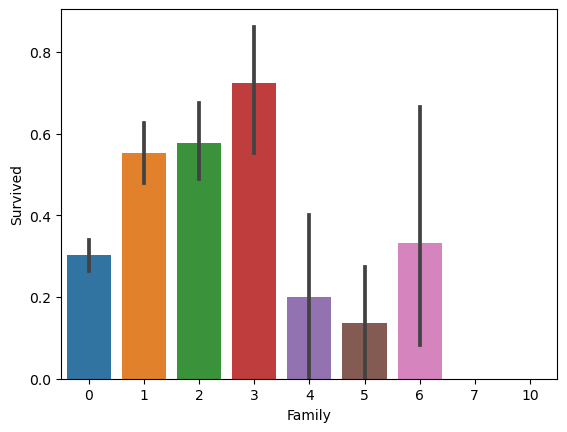

In [20]:
both['Family'] = both['SibSp'] + both['Parch']

sb.barplot(x='Family', y='Survived', data=both)
plt.show()

Proviamo poi un'altro approccio e cioè ridurre il range del dato Age categorizzandolo in 10 fasce di età nella colonna Age_cat; proviamo anche a ridurre il range del dato Fare (il costo del viaggio) dividendo anch'esso in 10 scaglioni nella colonna Fare_cat:

Legenda:
0 = 0->8 1 = 8->16 2 = 16->24 3 = 24->32 4 = 32->40 5 = 40->48 6 = 48->56 7 = 56->64 8 = 64->72 9 = 72->80 

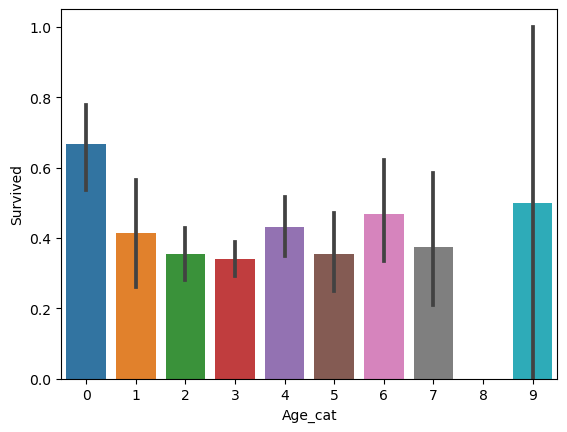

Legenda:
0 = 0->51 1 = 51->102 2 = 102->153 3 = 153->204 4 = 204->256 5 = 256->307 6 = 307->358 7 = 358->409 8 = 409->461 9 = 461->512 

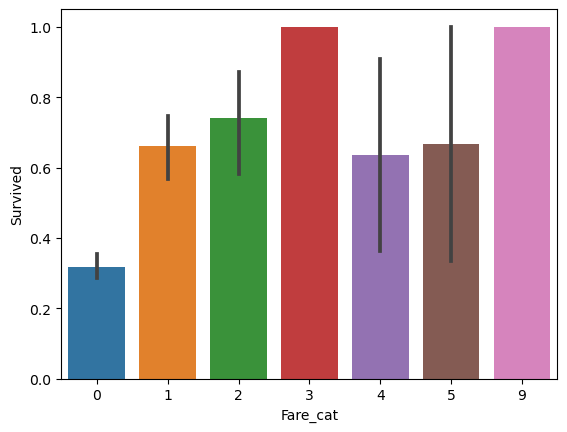

In [21]:
def add_age_cat(df):
    age_bins = 10
    age_cat, age_intervals = pd.cut(df.Age, bins=age_bins, labels=False, retbins=True)
    age_labels = []
    age_intervals[0] = 0
    age_intervals = age_intervals.astype(int)
    for i in range(len(age_intervals)):
        if i > 0:
            age_labels.append(f'{i - 1} = {age_intervals[i - 1]}->{age_intervals[i]}')
    print('Legenda:')
    for i in age_labels:
        print(f'{i}', end=' ')
    df['Age_cat'] = age_cat

def add_fare_cat(df):
    fare_bins = 10
    fare_cat, fare_intervals = pd.cut(df.Fare, bins=fare_bins, labels=False, retbins=True)
    fare_labels = []
    fare_intervals[0] = 0
    fare_intervals = fare_intervals.astype(int)
    for i in range(len(fare_intervals)):
        if i > 0:
            fare_labels.append(f'{i - 1} = {fare_intervals[i - 1]}->{fare_intervals[i]}')
    print('Legenda:')
    for i in fare_labels:
        print(f'{i}', end=' ')
    df['Fare_cat'] = fare_cat.astype(int)
      
add_age_cat(both)
sb.barplot(x='Age_cat', y='Survived', data=both)
plt.show()
add_fare_cat(both)
sb.barplot(x='Fare_cat', y='Survived', data=both)
plt.show()  

Nella colonna Fare_cat si nota come non ci sia nessun passeggero con spesa tra 307 e 461.
L'utilità delle colonne Family, Fare_cat e Age_cat verrà valutata in seguito.

L'ultima colonna aggiunta è un tentativo di estrarre delle informazioni dal nome: supponendo che un individuo di estrazione sociale più alta abbia più nomi e possibilmente anche dei titoli nobiliari, scriviamo nella colonna name_len il numero di parole che compone il nome di ogni passeggero:

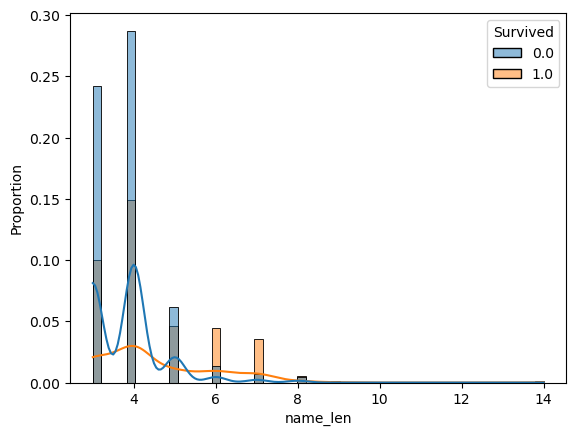

In [22]:
def add_wordsinname(df):
    words_in_name = []
    for name in df['Name'].tolist():
        words_in_name.append(len(name.split()))
    df['name_len'] = words_in_name
    df.drop('Name', axis=1, inplace=True)
add_wordsinname(both)
sb.histplot(data=both[~both.index.duplicated()], x='name_len', stat='proportion', kde=True, hue='Survived')
plt.show()


Infine visualizziamo la mappa di correlazione:

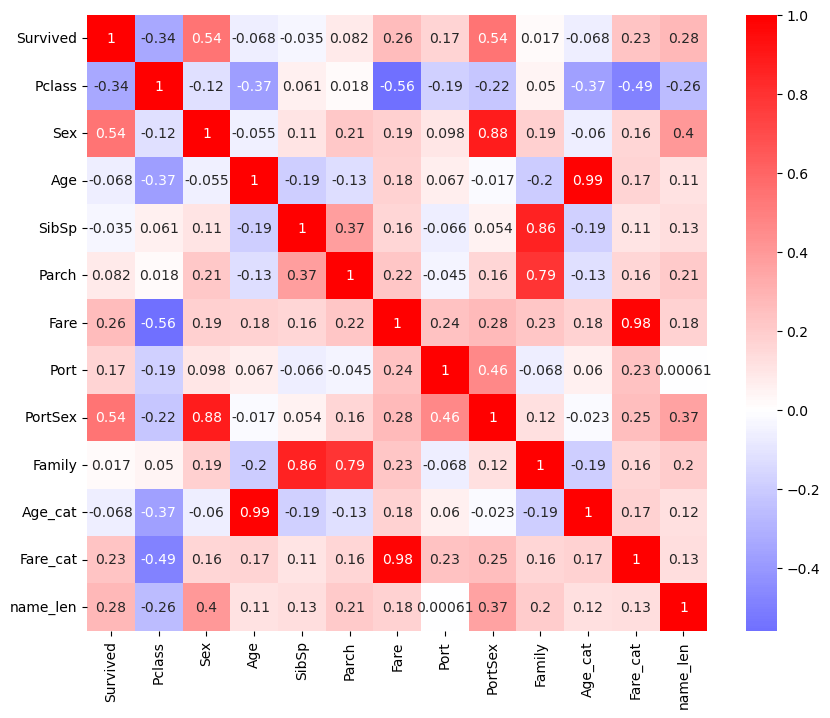

In [23]:
fig, ax = plt.subplots(figsize=(10,8))  # questo serve solo a ingrandire la heatmap e renderla leggibile

sb.heatmap(both.drop('PassengerId', axis=1).corr(), cmap = 'bwr', annot=True, center=0, ax=ax)
plt.show()

Il grafico si legge nel seguente modo:
- più una cella è vicina al rosso (e quindi al valore 1) e più sarà forte la correlazione lineare diretta tra i membri che la formano;
- più è vicina al blu (e quindi al valore -1) e più sarà forte la correlazione inversa tra i membri che la formano;
- più è vicina al bianco (cioè allo 0) e meno c'è correlazione.

A noi interessa la correlazione tra la colonna "Survived" e tutte le altre, quindi prendiamo in esame solo la prima colonna.
Osserviamo che:
- la correlazione tra "Survived" e se stesso è (ovviamente) 1;
- c'è correlazione positiva tra "Sex" e "Survived". Ricordando che se un passeggero è sopravvissuto il valore è 1 mentre se è morto è 0, e che il sesso è stato reso come f=1 e m=0, in linea con le osservazioni precedenti si evince che i passeggeri di sesso femminile hanno maggiore probabilità di sopravvivenza;
- la classe del biglietto ("Pclass") è inversamente correlata, quindi una classe con un valore più basso (che indica i passeggeri più abbienti) ha più probabilità di salvarsi;
- "Age" e "SibSp" sono inversamente correlati, quindi l'anzianità e la presenza di coniugi/fratelli/sorelle a bordo influiscono negativamente con le chance di sopravvivenza;
- "Parch" ha una correlazione positiva, quindi un passeggero accompagnato da un genitore (o inversamente dai figli) sembrerebbe avere più chance di salvarsi;
- la spesa a bordo ("Fare") ha una correlazione positiva;
- le colonne da noi generate Age_cat, Fare_cat, Family e Port hanno correlazione inferiore delle colonne da cui sono state generate quindi probabilmente non aumenteranno la precisione del modello o addiritturaa la diminuiranno, al contrario PortSex e name_len sembrano darci speranza.


Ora che abbiamo finito di analizzare e manipolare i nostri dati possiamo dividerli nuovamente in set di train e di test:

In [24]:
train = both.loc[both.Survived.notnull()]
test = both.loc[both.Survived.notnull() == False]

# Classificazione

Passiamo ora all'addestramento del nostro algoritmo di classificazione.

Prima di tutto dividiamo il set di train in un 85% che viene effettivamente utilizzata per l'addestramento e un 15% su cui useremo il modello addestrato per confrontare poi le predizioni con i dati reali e verificare di aver ottenuto una precisione apprezzabile.

In [25]:
from sklearn.model_selection import train_test_split

dropped_features = ['PassengerId', 'Survived', 'Age_cat', 'Fare_cat', 'Port', 'PortSex', 'Parch', 'SibSp']

x=train.drop(dropped_features, axis=1)
y=train['Survived'].astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

y = test.drop(dropped_features, axis=1)

Abbiamo anche provato ad introdurre uno scaler, e cioè a far lavorare gli algoritmi solo con dati normalizzati, ma senza notare miglioramenti. Il codice viene lasciato qui commentato a scopo documentale.

In [26]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = StandardScaler()
# # # scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# y = scaler.transform(test.drop(dropped_features, axis=1))

Qui viene istanziato e addestrato il classificatore, l'algoritmo scelto è il Random Forest Classifier in quanto ha mostrato i risultati migliori. Sono stati testati anche gli algoritmi di Nearest Neighbors, Support Vector Machine e Naive Bayes.

In [27]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB

clf=RandomForestClassifier()
# clf=KNeighborsClassifier(n_neighbors=7)
# clf=SVC()
# clf=GaussianNB()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

from sklearn import metrics
print(f'Accuracy: {(metrics.accuracy_score(y_test, y_pred) * 100):.2f}%')

Accuracy: 80.60%


Avendo constatato una precisione accettabile, non ci resta che far predirre all algoritmo i dati mancanti e generare il file con i risultati:

In [28]:
# y = test.drop(dropped_features, axis=1)
y_pred = clf.predict(y)
results = pd.DataFrame(({'PassengerId':test.PassengerId,'Survived':y_pred.astype(int)}))
results.to_csv('results.csv', index=False)